In [96]:
import datasets
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
import torch
import random

In [59]:

data = datasets.load_dataset('mnist')['train']

Found cached dataset mnist (/home/alekspet/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
X = np.array([np.array(im) for im in data['image']])/255


In [109]:
class Noise(object):
    def __init__(self, steps=1000, min_beta=0.0001, max_beta=0.001):
        betas = np.linspace(min_beta, max_beta, steps)
        alphas = 1 - betas
        cur = 1
        aprods = []
        for i in range(0, len(alphas)):
            cur*=alphas[i]
            aprods.append(cur)
        self.aprods = np.array(aprods)
        self.alphas = alphas
        
    def destroy(self,X, t):
        if t == 0:
            return X
        aprod = self.aprods[t]
        sample = torch.normal(0, 1, X.shape)
        result = math.sqrt(aprod)*X + math.sqrt(1-aprod)*sample
        result = torch.clip(result, -1, 1)
        return result
    
    def add_noise(self, X, t):
        alpha = self.alphas[t]
        sample = torch.normal(0, 1, X.shape)
        first = math.sqrt(alpha)*X 
        second = math.sqrt(1-alpha)*sample
        result = first + second
        result = torch.clip(result, -1, 1)
        return result, sample
    
    def subtract_noise(self, x, sample, t):
        alpha = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(torch.tensor(self.alphas[t]), -1), -1), -1)
        print(alpha.shape, sample.shape, x.shape)
        result =( x - torch.sqrt(1-alpha)*sample) / torch.sqrt(alpha)
        result = torch.clip(result, -1, 1)
        return result
    
    def destroy_by_steps(self, X, t):
        cur = X
        for i in range(t+1):
            cur, noise = self.add_noise(cur, i)
        return cur


In [110]:
def one_hot(x):
    res = np.zeros(10)
    res[x] = 1
    return res

In [111]:
y = np.array([one_hot(label) for label in data['label']])

In [112]:
x = torch.tensor(X[0])
all_ids = np.arange(len(data))
n = Noise()

In [138]:
def get_batch(size=64):
    ids = np.random.choice(all_ids, size)
    guidance = []
    ts = []
    X_batch = []
    output = []
    for id in ids:
        t = random.randint(0, 998)
        ts.append(t)
        x = torch.tensor(X[id])
        destroyed = n.destroy(x, t)
        res, noise = n.add_noise(destroyed, t+1)
        X_batch.append(res.numpy())
        output.append(noise.numpy())
        guidance.append(y[id])
        
    return (torch.tensor(np.array(X_batch)), torch.tensor(np.array(guidance)), 
            torch.tensor(np.array(ts)), torch.tensor(np.array(output)))



X_batch, guidance, ts, output = get_batch()

tensor(1) tensor(998)


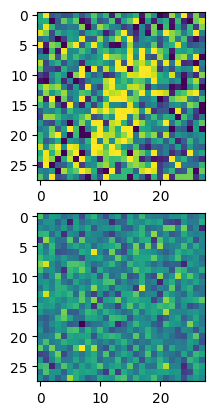

In [153]:
k=9
fig, ax = plt.subplots(2)
ax[0].imshow(X_batch[k])
ax[1].imshow(output[k])
print(np.argmax(guidance[k]), ts[k])

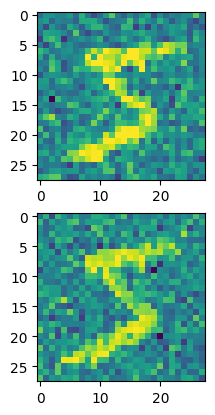

In [122]:
k = 300
fig, ax = plt.subplots(2)
ax[0].imshow(n.destroy(torch.tensor(X[0]), k))
cur = torch.tensor(X[0])
for i in range(k):    
    cur, noise = n.add_noise(cur, i)
ax[1].imshow(cur)